In [ ]:
#import Nesscery Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,confusion_matrix

# deep learning libraries

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout


In [ ]:
#insert the folder path train and test

train_path="/content/drive/MyDrive/Multiclassification_fish_project/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/train"
test_path="/content/drive/MyDrive/Multiclassification_fish_project/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test"

In [ ]:
# Initialize ImageDataGenerator with data augmentation settings

gen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# train generators

train_generator=gen.flow_from_directory(
    train_path,
    subset='training',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 4984 images belonging to 11 classes.


In [ ]:
#validation generators

validation_generator=gen.flow_from_directory(
    train_path,
    subset='validation',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 1241 images belonging to 11 classes.


In [ ]:
# it gives the next value of an iteration

x,y=next(train_generator)

In [ ]:
x.shape

(32, 224, 224, 3)

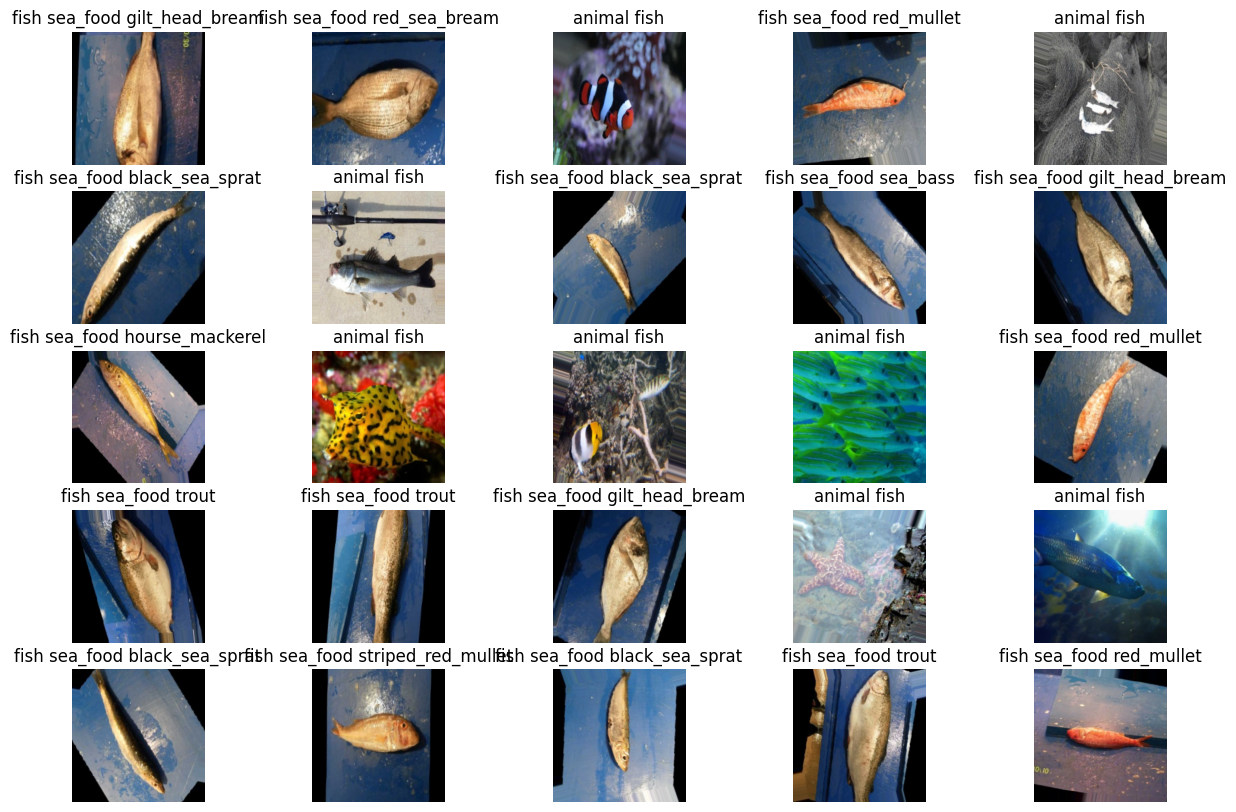

In [ ]:
# plotting image from train dataset

a = train_generator.class_indices
class_names = list(a.keys()) # storing the class/breed names in a list

def plot_images(img,labels):
  plt.figure(figsize=[15,10])
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(img[i])
    plt.title(class_names[labels[i].argmax()])
    plt.axis('off')

plot_images(x,y)

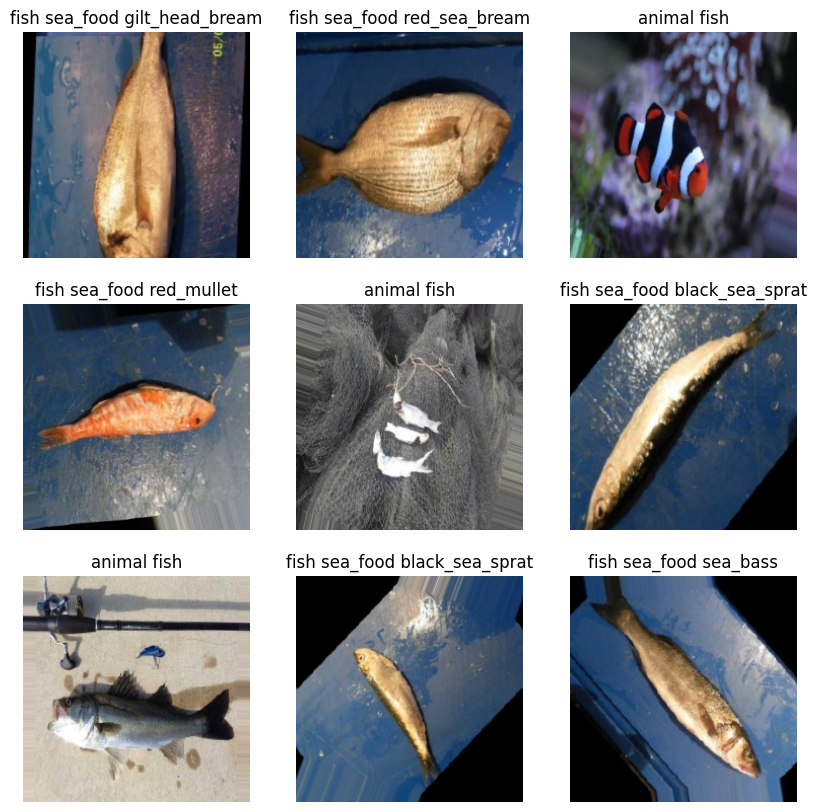

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x[i])   # Image is already rescaled (0-1 range)
    plt.title(list(train_generator.class_indices.keys())[np.argmax(y[i])])
    plt.axis("off")
plt.show()

                               Class  Image Count
0                        animal fish          877
1                   animal fish bass           24
2      fish sea_food black_sea_sprat          456
3      fish sea_food gilt_head_bream          453
4      fish sea_food hourse_mackerel          459
5           fish sea_food red_mullet          464
6        fish sea_food red_sea_bream          457
7             fish sea_food sea_bass          431
8               fish sea_food shrimp          461
9   fish sea_food striped_red_mullet          438
10               fish sea_food trout          464


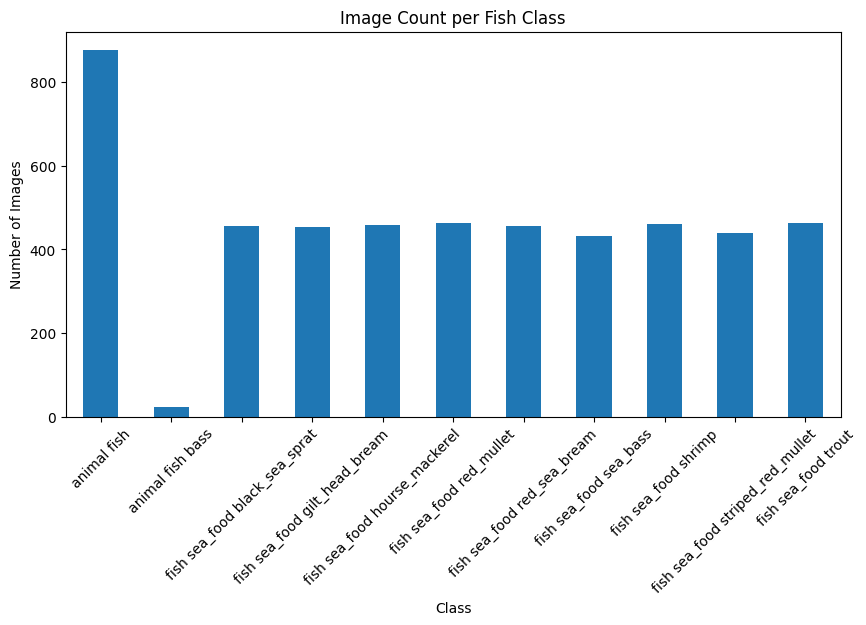

In [ ]:

# Class counts
class_counts = {cls: 0 for cls in train_generator.class_indices.keys()}
for cls, idx in train_generator.class_indices.items():
    class_counts[cls] = list(train_generator.classes).count(idx)

# Convert to DataFrame for easy visualization
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
print(df_counts)

# Plot
df_counts.plot(kind='bar', x='Class', y='Image Count', legend=False, figsize=(10,5), rot=45)
plt.title("Image Count per Fish Class")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
#Apply the CNN model from scratch

from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')  # output layer
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# compile the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,811 (91.20 MB)

 Trainable params: 23,908,811 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# defining call backs to preserve the best result
#Overfiting

early = tf.keras.callbacks.EarlyStopping(patience = 3,min_delta = 0.001,restore_best_weights = True)

In [ ]:
# train the model

batch_size = 32

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [ ]:
# fit the model

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    callbacks=[early]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1490s 10s/step - accuracy: 0.3207 - loss: 2.4320 - val_accuracy: 0.6488 - val_loss: 1.0841
Epoch 2/50
  1/155 ━━━━━━━━━━━━━━━━━━━━ 6:44 3s/step - accuracy: 0.5625 - loss: 1.1139

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 356ms/step - accuracy: 0.5625 - loss: 1.1139 - val_accuracy: 0.6242 - val_loss: 1.0806
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 621s 4s/step - accuracy: 0.6547 - loss: 0.9736 - val_accuracy: 0.7590 - val_loss: 0.7055
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 323ms/step - accuracy: 0.6875 - loss: 1.0998 - val_accuracy: 0.7599 - val_loss: 0.7006
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 621s 4s/step - accuracy: 0.7538 - loss: 0.7025 - val_accuracy: 0.7582 - val_loss: 0.6822
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 82s 512ms/step - accuracy: 0.6562 - loss: 0.8445 - val_accuracy: 0.7656 - val_loss: 0.6598
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 623s 4s/step - accuracy: 0.8001 - loss: 0.5613 - val_accuracy: 0.7763 - val_loss: 0.5993
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 318ms/step - accuracy: 0.9062 - loss: 0.3535 - val_accuracy: 0.7738 - val_loss: 0.6199
Epoch 9/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 611s 4s/step - accuracy: 0.8366 - loss: 0.4677 - val_accurac

In [ ]:
# store results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
# evalutae the accuracy of the CNN model

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print('Accuracy : {:.2f}%'.format(accuracy_score[1]*100))
#Converts the accuracy value to a percentage and prints it to two decimal places.
print('Loss:',accuracy_score[0])

# accuracy_score[0] will hold the loss value.
# accuracy_score[1] will hold the accuracy value.

39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9417 - loss: 0.2080
[0.19355686008930206, 0.9443996548652649]
Accuracy : 94.44%
Loss: 0.19355686008930206


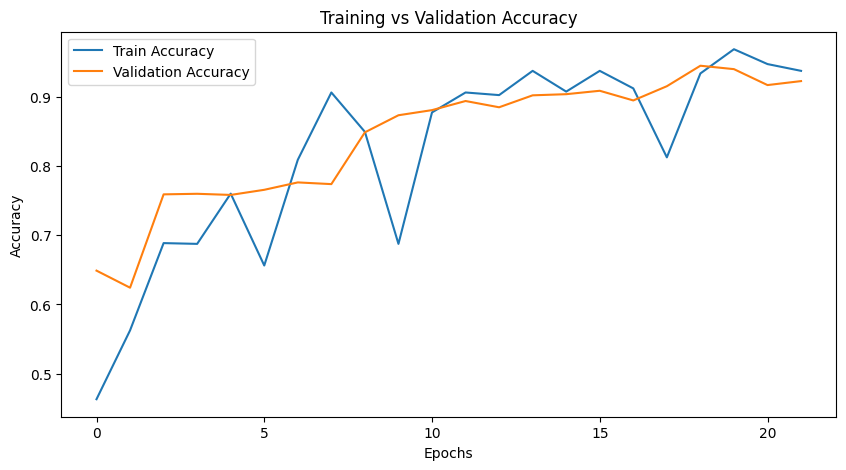

In [ ]:
# Plot training & validation accuracy

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

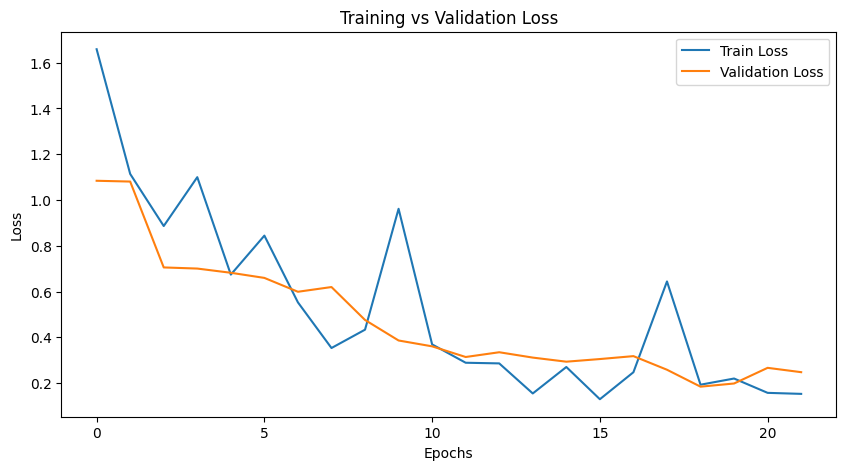

In [ ]:
# Plot training & validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
#Apply the simple Agumentation Setting Testing Process

test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
model.save("/content/drive/MyDrive/fish_models/fish_classifier.h5")


In [ ]:
#Testing Process

test_iter = test_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    class_mode=None,   # because no labels in test set
    shuffle=False,     # keeps order so predictions map to filenames
    batch_size=32
)


Found 3188 images belonging to 11 classes.


In [ ]:
# Predictions
preds = model.predict(test_iter)

100/100 ━━━━━━━━━━━━━━━━━━━━ 825s 8s/step


In [ ]:
model=load_model('/content/drive/MyDrive/fish_models/fish_classifier.h5')

In [ ]:
# Predictions
y_pred = model.predict(test_iter)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels from the generator
y_true = test_iter.classes

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1194s 12s/step


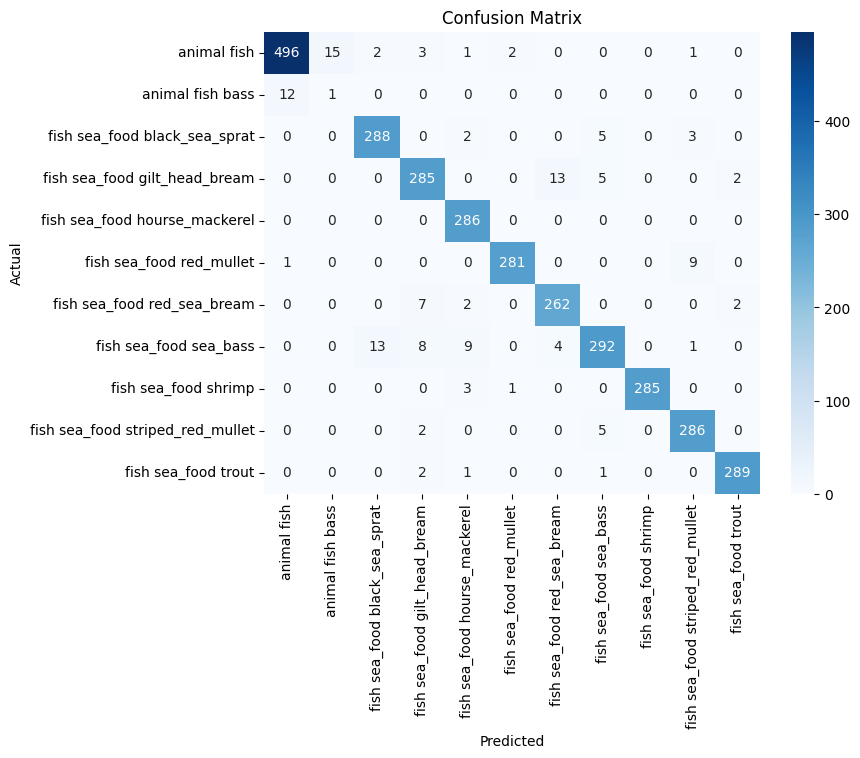

In [ ]:
#Confusion Matrix for Fish species

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_iter.class_indices.keys(),
            yticklabels=test_iter.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#Classification Report Precision,Recall,f1 Score

report = classification_report(y_true, y_pred_classes,
                               target_names=test_iter.class_indices.keys())
print(report)


                                  precision    recall  f1-score   support

                     animal fish       0.97      0.95      0.96       520
                animal fish bass       0.06      0.08      0.07        13
   fish sea_food black_sea_sprat       0.95      0.97      0.96       298
   fish sea_food gilt_head_bream       0.93      0.93      0.93       305
   fish sea_food hourse_mackerel       0.94      1.00      0.97       286
        fish sea_food red_mullet       0.99      0.97      0.98       291
     fish sea_food red_sea_bream       0.94      0.96      0.95       273
          fish sea_food sea_bass       0.95      0.89      0.92       327
            fish sea_food shrimp       1.00      0.99      0.99       289
fish sea_food striped_red_mullet       0.95      0.98      0.96       293
             fish sea_food trout       0.99      0.99      0.99       293

                        accuracy                           0.96      3188
                       macro avg    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Raw prediction: [[5.7113720e-08 8.8485059e-09 7.0179540e-01 1.3107560e-06 1.1987711e-03
  4.0758154e-05 2.9285563e-06 8.5285783e-04 2.9029162e-04 2.9581749e-01
  1.1747788e-07]]
Predicted class index: 2
Predicted class name: fish sea_food black_sea_sprat
Confidence: 0.7017954


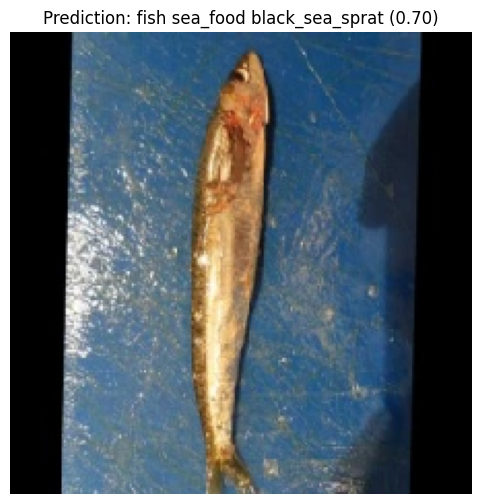

In [ ]:
#Testing simple code put one fish image

from tensorflow.keras.preprocessing.image import load_img, img_to_array


# ImageDataGenerator with rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load a single test image (make sure path is correct)
img = load_img("/content/0BAW6EAZQVLD.jpg", target_size=(224, 224))  # 224x224 is safe for most models
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)

# Apply generator (rescale only)
img_batch = test_datagen.flow(img_array, batch_size=1)
processed_img = next(img_batch)

# ---- PREDICTION STEP ----
pred = model.predict(processed_img)
predicted_index = np.argmax(pred)
confidence = np.max(pred)

# If you used ImageDataGenerator for training:
class_names = list(train_generator.class_indices.keys())

print("Raw prediction:", pred)
print("Predicted class index:", predicted_index)
print("Predicted class name:", class_names[predicted_index])
print("Confidence:", confidence)

# Show image
plt.figure(figsize=(6,6))
plt.title(f"Prediction: {class_names[predicted_index]} ({confidence:.2f})")
plt.imshow(processed_img[0])
plt.axis("off")
plt.show()
